The goal of this notebook is to provide a minimal working example of the suggested method for solving unsupervised classification problem. We use MNIST as our dataset. We choose pytorch-lightning as our framework, because it takes care of the training loop and therefore allows for a more transparent (and shorter) code, since you only need to define your model, loss function and choose the optimizer. Let's get started with installing it and importing the necessary libraries.

In [6]:
#%tensorflow_version 1.x
!pip install -q pytorch-lightning
import torch
from torch import nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split
from torch.nn import functional as F
from torchvision.datasets import MNIST
from torchvision import datasets, transforms
from collections import Counter
import os
import numpy as np

**Outline of the method**

Suppose we have any base model ending with a softmax layer, the dimension of the output vector is C -- number of classes. Then for each training example the output can be viewed as a probability distribution on C points, where argmax corresponds to the class assigned to the given example. Since we do not assume the knowledge of the actual classes for our examples, we want the following three things from the output:

1) **Confidence** 

For a fixed example, the prediction should be confident, i.e., the prediction should be close to a one-hot vector (delta distribution on one of the C points)

2) **Uniformity**

The average of predictions for all examples should be close to a uniform distribution. In practice the average will be taken over
 a batch.

Here we assume that the actual distribution of classes is uniform, which is not necessarily true in practice. This could be solved by labeling a small number of examples and therefore getting an approximation for the actual distribution.

3) **Continuity (invariance)**

The prediction should not change much for a small change in the input. For images a small affine transformation would constitute such a change.

Now let us implement a loss function which will enforce these 3 conditions on the output. Note that one can choose different measures of "closeness" for the above conditions. In particular, the confidence of predictions can be enforced by either taking the entropy of the distribution corresponding to that prediction, or just by taking the distance from the corresponding point in $\mathbb{R}^{C}$ to the center of the simplex (the space of all probability measures on $C$ points is a simplex on $\mathbb{R}^{C}$, where delta-measures correspond to the vertices of the simplex, and uniform distribution corresponds to its center). We will use distance as it provides more stable results.

In [2]:
def full_loss(logits, loss_type, num_classes, prefix='train'):
    '''
        Takes a tensor of predictions -- logits and returns a dictionary with all 3 losses mentioned above, as well as their sum
        loss_type corresponds to the choice of measure of closeness, could be distance or entropy
        logits tensor will be a concatenation of the predictions on a batch with predictions on augmentations mentioned in 3)
    '''
    current_batch_size = logits.shape[0]
    logits, transformed_logits = logits[:current_batch_size//2], logits[current_batch_size//2:]
    mean_logits = torch.mean(logits, axis=0)

    if loss_type == 'distance':
        loss1 = torch.linalg.norm(mean_logits-torch.ones_like(mean_logits)/num_classes)
        simplex_vertex = torch.zeros_like(mean_logits)
        simplex_vertex[0] = simplex_vertex[0] + 1
        max_dist = torch.linalg.norm(simplex_vertex-torch.ones_like(mean_logits)/num_classes)
        loss2 = max_dist - torch.mean(torch.linalg.norm(logits-torch.ones_like(logits)/num_classes, dim=1))
    
    #TODO: normalize, so that the minimum for each loss is 0
    if loss_type == 'entropy':
        loss1 = entropy_loss(mean_logits)
        loss2 = -torch.mean(entropy_loss(logits))

    loss3 = torch.mean(torch.linalg.norm(logits - transformed_logits, dim=1))

    #TODO: experiment with coefficients
    loss = 1.*loss1 + 1.*loss2 + 1.*loss3
    return {prefix + '_loss' : loss, prefix + '_loss1' : loss1, prefix + '_loss2' : loss2, prefix + '_loss3' : loss3}

def entropy_loss(self, logits):
    ent = logits * torch.log(logits+0.000001)
    return ent.sum(axis=-1)

Now let us define the transformation mentioned in 3) above, as well as a few helper functions. In particular, we define a function which measures the accuracy of predictions. Since we don't use the actual labels when training, the predicted labels could be any permutation of actual labels, so to calculate the accuracy, we need to find the dominating true labels in each predicted class, and calculate the accuracy as if all examples from that predicted class had this true label. 

In [3]:
train_transform = transforms.Compose(
                    [
                    transforms.RandomAffine(degrees=20, translate=(0.1,0.1), scale=(0.9, 1.1))
                    ])

def get_cluster_acc(true_labels, predicted_labels):
    counters = []
    for i in np.unique(predicted_labels).tolist():
        counters.append(Counter(true_labels[predicted_labels==i]))
    return sum([max(counter.values()) for counter in counters]) / true_labels.shape[0]

def numpify(t):
    return t.detach().cpu().numpy()

def numpify_list(l):
    return [numpify(t) for t in l]

Now we define the architecture of the model that will be used. We choose a simple convolutional network with 2 conv-relu-maxpool blocks followed by 2 dense layers.

In [4]:
def get_model():
    activation = nn.ReLU()
    model = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
        activation,
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
        activation,
        nn.MaxPool2d(kernel_size=2, stride=2),
        
        nn.Flatten(),
        nn.Linear(7 * 7 * 64, 1000),
        activation,
        nn.Linear(1000, 10)
    )
    return model 

The final step is to combine everything in one Pytorch-Lightning module and train the model

In [9]:
class UnsupervisedMnist(pl.LightningModule):

    def __init__(self, batch_size, criterion = full_loss, loss_type='distance', lr=1e-4):
        super(UnsupervisedMnist, self).__init__()

        self.batch_size = batch_size
        self.num_classes = 10

        self.criterion = criterion
        self.loss_type = loss_type
        self.lr = lr

        self.model = get_model()
        self.accs = []

    def forward(self, x):
        out = self.model(x)
        out = torch.softmax(out, dim=1)
        return out

    def training_step(self, batch, batch_idx):
        x, _ = batch #note that we are not using labels for training
        transformed = train_transform(x)
        x = torch.cat([x, transformed])
        logits = self.forward(x)
        loss_dict = self.criterion(logits, self.loss_type, self.num_classes, 'train')
        self.log_dict(loss_dict, prog_bar=True)
        loss = loss_dict['train_loss']
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        transformed = train_transform(x)
        x = torch.cat([x, transformed])
        logits = self.forward(x)
        loss_dict = self.criterion(logits, self.loss_type, self.num_classes, 'val')

        _, predicted_labels = torch.max(logits[:logits.shape[0]//2], dim=1)

        d = {'val_loss' : loss_dict['val_loss'], 'true_labels' : y, 'predicted_labels' : predicted_labels}
        return d

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        true_labels = torch.cat([x['true_labels'] for x in outputs])
        predicted_labels = torch.cat([x['predicted_labels'] for x in outputs])

        acc = get_cluster_acc(numpify(true_labels), numpify(predicted_labels))
        self.accs.append(acc)
        d = {'val_loss' : avg_loss, 'val_acc' : acc}
        self.log_dict(d, prog_bar=True)

    def prepare_data(self):
        transform=transforms.Compose([transforms.ToTensor(), 
                                    transforms.Normalize((0.1307,), (0.3081,))])

        mnist_train = MNIST(os.getcwd(), train=True, download=True, transform=transform)
        mnist_test = MNIST(os.getcwd(), train=False, download=True, transform=transform)
        
        self.mnist_train, self.mnist_val = random_split(mnist_train, [55000, 5000])

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

# train
model = UnsupervisedMnist(batch_size=200, lr=1e-4)
trainer = pl.Trainer(gpus=1, max_epochs = 500, progress_bar_refresh_rate=20)
trainer.fit(model)


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 3.2 M 
-------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params


/usr/local/lib/python3.6/dist-packages/torchvision/transforms/functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

Best accuracy -- 0.9896


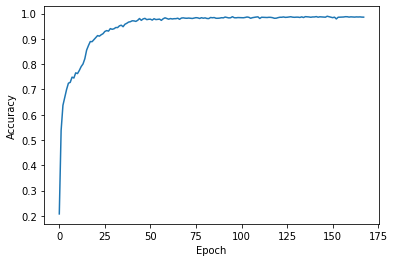

In [10]:
print('Best accuracy --', max(model.accs))
import matplotlib.pyplot as plt
plt.plot(model.accs)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()
#model.accs